# Evaluation metric
In this notebook I'll try to explain and implement the competition metrics. 

If you find a bug please leave a comment. Thanks.

And do not forget to vote :)

-----
**UPDATE v2 - <span style="color:red">BUG fix!</span>**

Inside the `calculate_precision` function I did not pass the `form` param, it was hardcoded `coco`.
This caused wrong calculations if you used the `pascal_voc` format.

**UPDATE v3 - <span style="color:red">Optimized with Numba!</span>**
- I optimized the code, so with help of numba it will run much faster
- Added the tips of Alexander (see the comments below)
- <span style="color:red">Importnat change</span>: In some of the methods the order of the `gt_box`, `pred_box` arguments were mixed. Please double check your code. The correct order is `gt` first, `pred` second.

**UPDATE v4 - <span style="color:red">Another BUG fixed!</span>**

In [1]:
import pandas as pd
import numpy as np
import numba
import re
import cv2
import ast
import matplotlib.pyplot as plt

from numba import jit
from typing import List, Union, Tuple

DIR_INPUT = '/kaggle/input/global-wheat-detection'
DIR_TRAIN = f'{DIR_INPUT}/train'
DIR_TEST = f'{DIR_INPUT}/test'

# Intersection over Union (IoU)
> Intersection over Union is a measure of the magnitude of overlap between two bounding boxes (or, in the more general case, two objects). It calculates the size of the overlap between two objects, divided by the total area of the two objects combined.
>
> It can be visualized as the following:
> ![iou](https://storage.googleapis.com/kaggle-media/competitions/rsna/IoU.jpg) 
>
> The two boxes in the visualization overlap, but the area of the overlap is insubstantial compared with the area taken up by both objects together. IoU would be low - and would likely not count as a "hit" at higher IoU thresholds.

### About the `form` param
I made a mistake in my starter notebook. I did not know that `Albumentation` accepts the box coordinates in many formats, so my starter code could be a bit confusing.
In this notebook, I implemented both formats, so you can use whatever you prefer:

- **pascal_voc**: min/max coordinates `[x_min, y_min, x_max, y_max]`
- **coco**: width/height instead of maxes `[x_min, y_min, width, height]`

Make sure you use the same format everywhere (including during your train/validation/inference calculations)

## IOU Calculation

In [2]:
@jit(nopython=True)
def calculate_iou(gt, pr, form='pascal_voc') -> float:
    """Calculates the Intersection over Union.

    Args:
        gt: (np.ndarray[Union[int, float]]) coordinates of the ground-truth box
        pr: (np.ndarray[Union[int, float]]) coordinates of the prdected box
        form: (str) gt/pred coordinates format
            - pascal_voc: [xmin, ymin, xmax, ymax]
            - coco: [xmin, ymin, w, h]
    Returns:
        (float) Intersection over union (0.0 <= iou <= 1.0)
    """
    if form == 'coco':
        gt = gt.copy()
        pr = pr.copy()

        gt[2] = gt[0] + gt[2]
        gt[3] = gt[1] + gt[3]
        pr[2] = pr[0] + pr[2]
        pr[3] = pr[1] + pr[3]

    # Calculate overlap area
    dx = min(gt[2], pr[2]) - max(gt[0], pr[0]) + 1
    
    if dx < 0:
        return 0.0
    
    dy = min(gt[3], pr[3]) - max(gt[1], pr[1]) + 1

    if dy < 0:
        return 0.0

    overlap_area = dx * dy

    # Calculate union area
    union_area = (
            (gt[2] - gt[0] + 1) * (gt[3] - gt[1] + 1) +
            (pr[2] - pr[0] + 1) * (pr[3] - pr[1] + 1) -
            overlap_area
    )

    return overlap_area / union_area


### No overlapping

In [3]:
box1 = np.array([834.0, 222.0, 56.0, 36.0])
box2 = np.array([26.0, 144.0, 124.0, 117.0])

assert calculate_iou(box1, box2, form='coco') == 0.0

### Partial (50%) overlapping

In [4]:
box1 = np.array([100, 100, 100, 100])
box2 = np.array([100, 100, 200, 100])

res = calculate_iou(box1, box2, form='coco')
assert  res > 0.5 and res < 0.50249

### Full overlapping

In [5]:
box1 = np.array([834.0, 222.0, 56.0, 36.0])
box2 = box1

assert calculate_iou(box1, box2, form='coco') == 1.0

# Mean Average Precision

> This competition is evaluated on the mean average precision at different intersection over union (IoU) thresholds. The IoU of a set of predicted bounding boxes and ground truth bounding boxes is calculated as:
>
> $$IoU(A, B) = \frac{A\cap B}{A\cup B}$$
>
>The metric sweeps over a range of IoU thresholds, at each point calculating an average precision value. The threshold values range from 0.5 to 0.75 with a step size of 0.05. In other words, at a threshold of 0.5, a predicted object is considered a "hit" if its intersection over union with a ground truth object is greater than 0.5.
>
> At each threshold value t, a precision value is calculated based on the number of true positives (TP), false negatives (FN), and false positives (FP) resulting from comparing the predicted object to all ground truth objects:
>
> $$Precision(t)=\frac{TP(t)}{TP(t) + FP(t) + FN(t)}$$
>

- A **true positive** is counted when a single predicted object matches a ground truth object with an IoU above the threshold.
- A **false positive** indicates a predicted object had no associated ground truth object.
- A **false negative** indicates a ground truth object had no associated predicted object.

> **Important note**: if there are no ground truth objects at all for a given image, ANY number of predictions (false positives) will result in the image receiving a score of zero, and being included in the mean average precision.
>
> The average precision of a single image is calculated as the mean of the above precision values at each IoU threshold:
>
> $$Avg. Precision = \frac{1}{n_{thresh}}*\sum_{t=1}^{n} precision(t)$$
>
> In your submission, you are also asked to provide a confidence level for each bounding box. Bounding boxes will be evaluated in order of their confidence levels in the above process. This means that bounding boxes with higher confidence will be checked first for matches against solutions, which determines what boxes are considered true and false positives.
>
>Lastly, the score returned by the competition metric is the mean taken over the individual average precisions of each image in the test dataset.

In [6]:
train_df = pd.read_csv(f'{DIR_INPUT}/train.csv')
train_df.shape

(147793, 5)

In [7]:
# From Andrew's kernel
box_data = np.stack(train_df['bbox'].apply(lambda x: ast.literal_eval(x)))
train_df[['x', 'y', 'w', 'h']] = pd.DataFrame(box_data).astype(np.float32)

## MAP calculation

In [8]:
@jit(nopython=True)
def find_best_match(gts, pred, pred_idx, threshold = 0.5, form = 'pascal_voc', ious=None) -> int:
    """Returns the index of the 'best match' between the
    ground-truth boxes and the prediction. The 'best match'
    is the highest IoU. (0.0 IoUs are ignored).

    Args:
        gts: (List[List[Union[int, float]]]) Coordinates of the available ground-truth boxes
        pred: (List[Union[int, float]]) Coordinates of the predicted box
        pred_idx: (int) Index of the current predicted box
        threshold: (float) Threshold
        form: (str) Format of the coordinates
        ious: (np.ndarray) len(gts) x len(preds) matrix for storing calculated ious.

    Return:
        (int) Index of the best match GT box (-1 if no match above threshold)
    """
    best_match_iou = -np.inf
    best_match_idx = -1

    for gt_idx in range(len(gts)):
        
        if gts[gt_idx][0] < 0:
            # Already matched GT-box
            continue
        
        iou = -1 if ious is None else ious[gt_idx][pred_idx]

        if iou < 0:
            iou = calculate_iou(gts[gt_idx], pred, form=form)
            
            if ious is not None:
                ious[gt_idx][pred_idx] = iou

        if iou < threshold:
            continue

        if iou > best_match_iou:
            best_match_iou = iou
            best_match_idx = gt_idx

    return best_match_idx

@jit(nopython=True)
def calculate_precision(gts, preds, threshold = 0.5, form = 'coco', ious=None) -> float:
    """Calculates precision for GT - prediction pairs at one threshold.

    Args:
        gts: (List[List[Union[int, float]]]) Coordinates of the available ground-truth boxes
        preds: (List[List[Union[int, float]]]) Coordinates of the predicted boxes,
               sorted by confidence value (descending)
        threshold: (float) Threshold
        form: (str) Format of the coordinates
        ious: (np.ndarray) len(gts) x len(preds) matrix for storing calculated ious.

    Return:
        (float) Precision
    """
    n = len(preds)
    tp = 0
    fp = 0
    
    # for pred_idx, pred in enumerate(preds_sorted):
    for pred_idx in range(n):

        best_match_gt_idx = find_best_match(gts, preds[pred_idx], pred_idx,
                                            threshold=threshold, form=form, ious=ious)

        if best_match_gt_idx >= 0:
            # True positive: The predicted box matches a gt box with an IoU above the threshold.
            tp += 1
            # Remove the matched GT box
            gts[best_match_gt_idx] = -1

        else:
            # No match
            # False positive: indicates a predicted box had no associated gt box.
            fp += 1

    # False negative: indicates a gt box had no associated predicted box.
    fn = (gts.sum(axis=1) > 0).sum()

    return tp / (tp + fp + fn)


@jit(nopython=True)
def calculate_image_precision(gts, preds, thresholds = (0.5, ), form = 'coco') -> float:
    """Calculates image precision.

    Args:
        gts: (List[List[Union[int, float]]]) Coordinates of the available ground-truth boxes
        preds: (List[List[Union[int, float]]]) Coordinates of the predicted boxes,
               sorted by confidence value (descending)
        thresholds: (float) Different thresholds
        form: (str) Format of the coordinates

    Return:
        (float) Precision
    """
    n_threshold = len(thresholds)
    image_precision = 0.0
    
    ious = np.ones((len(gts), len(preds))) * -1
    # ious = None

    for threshold in thresholds:
        precision_at_threshold = calculate_precision(gts.copy(), preds, threshold=threshold,
                                                     form=form, ious=ious)
        image_precision += precision_at_threshold / n_threshold

    return image_precision

For local validation, you need to calculate image precision for all of your validation images and take the average.

```python
validation_image_precision = []
iou_thresholds = [x for x in np.arange(0.5, 0.76, 0.05)]

for images, targets in valid_data_loader:
    # ...
    #
    # outputs = model.forward(images)
    #
    # ...
    #
    # preds = ... # shape: (#predicted box, 4)
    # scores = ... # shape: (#predicted box, )
    # gt_boxes = ... # shape: (#ground-truth box, 4)
    
    preds_sorted_idx = np.argsort(scores)[::-1]
    preds_sorted = preds[preds_sorted_idx]
    
    for idx, image in enumerate(images):
        image_precision = calculate_image_precision(preds_sorted,
                                                    gt_boxes,
                                                    thresholds=iou_thresholds,
                                                    form='coco')
        
        validation_image_precisions.append(image_precision)

print("Validation IOU: {0:.4f}".format(np.mean(validation_image_precisions))
```

# Testing

In [9]:
# Our testing sample
sample_id = '1ef16dab1'

gt_boxes = train_df[train_df['image_id'] == sample_id][['x', 'y', 'w', 'h']].values
gt_boxes = gt_boxes.astype(np.int)

# Ground-truth boxes of our sample
gt_boxes

array([[954, 391,  70,  90],
       [660, 220,  95, 102],
       [ 64, 209,  76,  57],
       [896,  99, 102,  69],
       [747, 460,  72,  77],
       [885, 163, 103,  69],
       [514, 399,  90,  97],
       [702, 794,  97,  99],
       [721, 624,  98, 108],
       [826, 512,  82,  94],
       [883, 944,  79,  74],
       [247, 594, 123,  92],
       [673, 514,  95, 113],
       [829, 847, 102, 110],
       [ 94, 737,  92, 107],
       [588, 568,  75, 107],
       [158, 890, 103,  64],
       [744, 906,  75,  79],
       [826,  33,  72,  74],
       [601,  69,  67,  87]])

In [10]:
# No GT - Predicted box match
pred_box = np.array([0, 0, 10, 10])
assert find_best_match(gt_boxes, pred_box, 0, threshold=0.5, form='coco') == -1

# First GT match
pred_box = np.array([954., 391., 70., 90.])
assert find_best_match(gt_boxes, pred_box, 0, threshold=0.5, form='coco') == 0

In [11]:
# These are the predicted boxes (and scores) from my locally trained model.
preds = np.array([[956, 409, 68, 85],
                  [883, 945, 85, 77],
                  [745, 468, 81, 87],
                  [658, 239, 103, 105],
                  [518, 419, 91, 100],
                  [711, 805, 92, 106],
                  [62, 213, 72, 64],
                  [884, 175, 109, 68],
                  [721, 626, 96, 104],
                  [878, 619, 121, 81],
                  [887, 107, 111, 71],
                  [827, 525, 88, 83],
                  [816, 868, 102, 86],
                  [166, 882, 78, 75],
                  [603, 563, 78, 97],
                  [744, 916, 68, 52],
                  [582, 86, 86, 72],
                  [79, 715, 91, 101],
                  [246, 586, 95, 80],
                  [181, 512, 93, 89],
                  [655, 527, 99, 90],
                  [568, 363, 61, 76],
                  [9, 717, 152, 110],
                  [576, 698, 75, 78],
                  [805, 974, 75, 50],
                  [10, 15, 78, 64],
                  [826, 40, 69, 74],
                  [32, 983, 106, 40]]
                )

scores = np.array([0.9932319, 0.99206185, 0.99145633, 0.9898089, 0.98906296, 0.9817738,
                   0.9799762, 0.97967803, 0.9771589, 0.97688967, 0.9562935, 0.9423076,
                   0.93556845, 0.9236257, 0.9102379, 0.88644403, 0.8808225, 0.85238415,
                   0.8472188, 0.8417798, 0.79908705, 0.7963756, 0.7437897, 0.6044758,
                   0.59249884, 0.5557045, 0.53130984, 0.5020239])

# Sort highest confidence -> lowest confidence
preds_sorted_idx = np.argsort(scores)[::-1]
preds_sorted = preds[preds_sorted_idx]

In [12]:
def show_result(sample_id, preds, gt_boxes):
    sample = cv2.imread(f'{DIR_TRAIN}/{sample_id}.jpg', cv2.IMREAD_COLOR)
    sample = cv2.cvtColor(sample, cv2.COLOR_BGR2RGB)

    fig, ax = plt.subplots(1, 1, figsize=(16, 8))

    for pred_box in preds:
        cv2.rectangle(
            sample,
            (pred_box[0], pred_box[1]),
            (pred_box[0] + pred_box[2], pred_box[1] + pred_box[3]),
            (220, 0, 0), 2
        )

    for gt_box in gt_boxes:    
        cv2.rectangle(
            sample,
            (gt_box[0], gt_box[1]),
            (gt_box[0] + gt_box[2], gt_box[1] + gt_box[3]),
            (0, 0, 220), 2
        )

    ax.set_axis_off()
    ax.imshow(sample)
    ax.set_title("RED: Predicted | BLUE - Ground-truth")

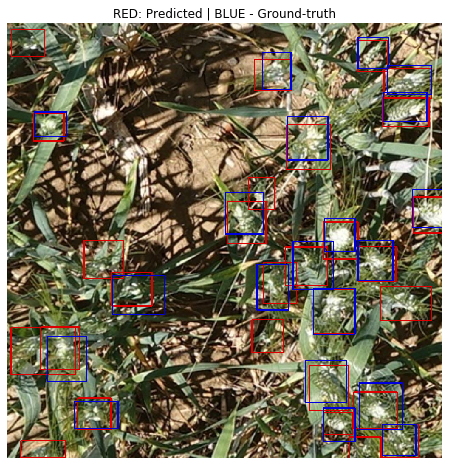

In [13]:
show_result(sample_id, preds, gt_boxes)

In [14]:
precision = calculate_precision(gt_boxes.copy(), preds_sorted, threshold=0.5, form='coco')
print("Precision at threshold 0.5: {0:.4f}".format(precision))

Precision at threshold 0.5: 0.6552


In [15]:
precision = calculate_precision(gt_boxes.copy(), preds_sorted, threshold=0.75, form='coco')
print("Precision at threshold 0.75: {0:.4f}".format(precision))

Precision at threshold 0.75: 0.0909


In [16]:
# Numba typed list!
iou_thresholds = numba.typed.List()

for x in [0.5, 0.55, 0.6, 0.65, 0.7, 0.75]:
    iou_thresholds.append(x)

In [17]:
image_precision = calculate_image_precision(gt_boxes, preds_sorted,
                                            thresholds=iou_thresholds,
                                            form='coco')

print("The average precision of the sample image: {0:.4f}".format(image_precision))

The average precision of the sample image: 0.3827


---------------------------------

**Thanks for reading. Please vote if you find this notebook useful.**

In [18]:
#